In [3]:
!pip install datasets transformers albumentations huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.4 MB/s eta 0:00:00


In [2]:
# NEW ALGO #

"""
to deal with inconsistently labelled data
we will train our model on the original data
then we will use the output maps from this model
and combine them with original maps using (logical OR)
then re-train and check results

"""

'\nto deal with inconsistently labelled data\nwe will train our model on the original data\nthen we will use the output maps from this model\nand combine them with original maps using (logical OR)\nthen re-train and check results\n\n'

In [4]:
from datasets import load_dataset

# v1 is original RGB dataset
# v2 is with some extra preprocessing that was needed for maskformer (not needed in upernet)
# v3 is with RGB + NIR channel dataset (poor performance on this one)

dataset = load_dataset("jaygala223/38-cloud-train-only-v1")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8400 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8400
    })
})

In [ ]:
# # exclude bad labels

# bad_labels = [35, 36]

# dataset['train'] = dataset['train'].select(
#     (
#         i for i in range(dataset['train'].num_rows)
#         if i not in set(bad_labels)
#     )
# )

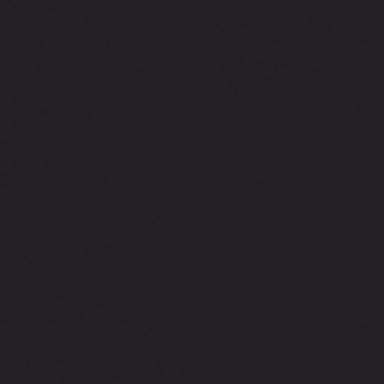

In [ ]:
dataset['train'][2500]['image']

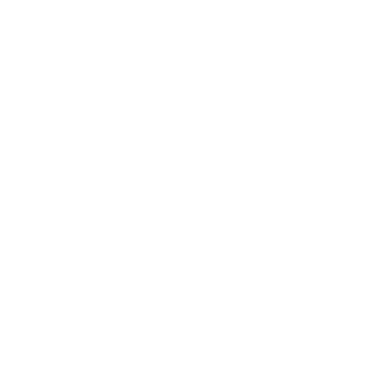

In [ ]:
dataset['train'][2500]['label']

In [6]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.1)
train_ds = dataset["train"]
test_ds = dataset["test"]

In [5]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'label'],
    num_rows: 7560
})
Dataset({
    features: ['image', 'label'],
    num_rows: 840
})


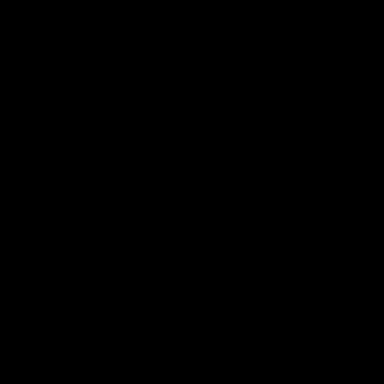

In [ ]:
# let's look at one example
example = train_ds[39]
image = example['image']
image

In [ ]:
import numpy as np
np.array(image).shape

(384, 384, 3)

In [7]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['label'])/255
segmentation_map = np.array(segmentation_map, dtype=np.uint8)
segmentation_map

NameError: ignored

In [ ]:
np.unique(segmentation_map)

array([0], dtype=uint8)

In [7]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"jaygala223/38-cloud-train-only-v1"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'non-cloud', 255: 'cloud'}


In [ ]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    # return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
    #         [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
    #         [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
    #         [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
    #         [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
    #         [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
    #         [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
    #         [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
    #         [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
    #         [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
    #         [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
    #         [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
    #         [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
    #         [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
    #         [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
    #         [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
    #         [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
    #         [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
    #         [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
    #         [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
    #         [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
    #         [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
    #         [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
    #         [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
    #         [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
    #         [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
    #         [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
    #         [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
    #         [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
    #         [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
    #         [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
    #         [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
    #         [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
    #         [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
    #         [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
    #         [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
    #         [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
    #         [102, 255, 0], [92, 0, 255]]

    #since we only have 2 classes
    return [[102, 255, 0], [92, 0, 255]]

palette = color_palette()

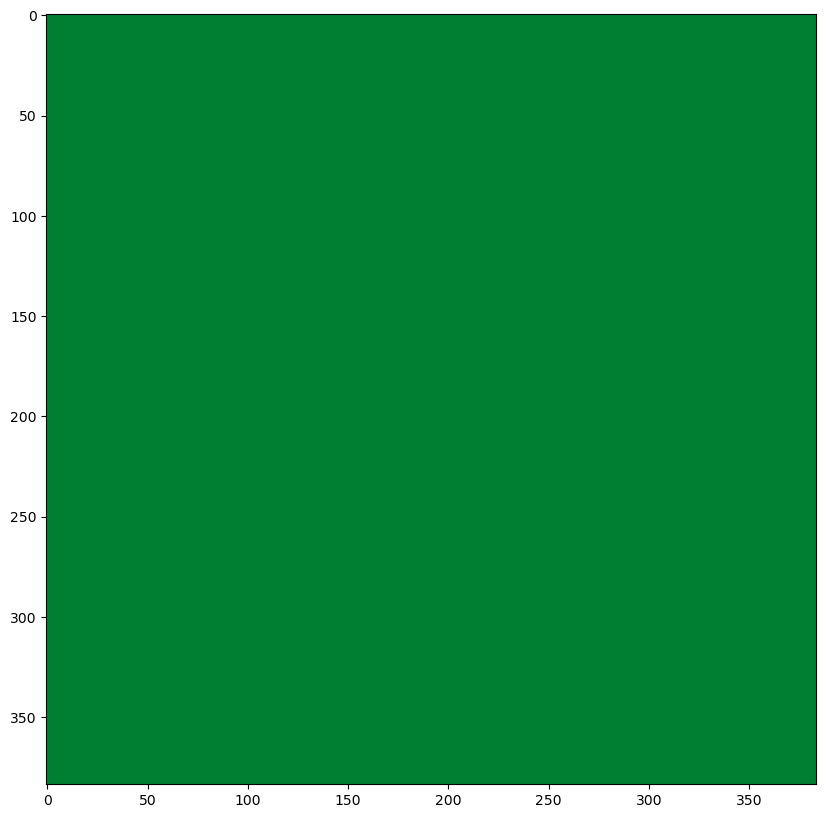

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [8]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['label'])

        # adding one bottom most pixel as 255 since processor/feature_extractor
        # wont take labels without a positive (i.e. class: 1 or cloud)
        uniques = np.unique(original_segmentation_map)
        if sum(uniques) == 0:
            original_segmentation_map[-1, -1] = 255

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [9]:
import albumentations as A


ADE_MEAN = np.array([100, 100, 100]) / 255
ADE_STD = np.array([100, 100, 100]) / 255

train_transform = A.Compose([
    # A.LongestMaxSize(max_size=384),
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    # A.Resize(width=100, height=100),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

# train_dataset = ImageSegmentationDataset(train_ds)
train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)
# test_dataset = ImageSegmentationDataset(test_ds)

In [11]:
# image, segmentation_map, _, _ = train_dataset[0]
image, segmentation_map, _, _ = train_dataset[222]
print(image.shape)
print(segmentation_map.shape)

(3, 384, 384)
(384, 384)


In [10]:
from transformers import MaskFormerImageProcessor,Mask2FormerImageProcessor, AutoImageProcessor

# Create a preprocessor
# preprocessor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                   do_reduce_labels=False,
#                                                   do_resize=False, do_rescale=False, do_normalize=False)

size = {'longest_edge':384, 'shortest_edge':384}

#original
preprocessor = MaskFormerImageProcessor(ignore_index=0,
                                        do_reduce_labels=False,
                                        do_resize=False,
                                        do_rescale=False,
                                        do_normalize=False,
                                        size=size)


#my experiment
# preprocessor = Mask2FormerImageProcessor(ignore_index=0, do_reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [11]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

In [12]:

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# batch size more than 2 causes CUDA out of memory error

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [13]:
import torch

batch = next(iter(train_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])
mask_labels torch.Size([1, 384, 384])
class_labels torch.Size([1])
original_images (384, 384, 3)
original_segmentation_maps (384, 384)


In [22]:
from transformers import MaskFormerForInstanceSegmentation, Mask2FormerForUniversalSegmentation

# Replace the head of the pre-trained model

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-IN21k-ade-semantic",
#                                                             id2label=id2label,
#                                                             ignore_mismatched_sizes=True)


from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b3-finetuned-ade-512-512")

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-tiny-ade-semantic",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("jaygala223/maskformer-finetuned-for-38-cloud-dataset",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

# model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-tiny-coco",
#                                                           id2label=id2label,
#                                                           ignore_mismatched_sizes=True)

model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024",
                                                         id2label=id2label,
                                                         ignore_mismatched_sizes=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-cityscapes-512-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation, AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
import requests

size = {'longest_edge':384, 'shortest_edge':383}

# load MaskFormer fine-tuned on COCO panoptic segmentation
# feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-tiny-coco",
#                                                                size=size,
#                                                                )

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")

# model 1 is for generating new pred segmentation maps... model 2 is to train on new pred labels

# image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-tiny")
# model1 = UperNetForSemanticSegmentation.from_pretrained("jaygala223/upernet-swin-tiny-finetuned-for-38-cloud-dataset")
# model2 = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-tiny")

In [24]:
import torch
device = "cuda"
batch = next(iter(train_dataloader))

images, labels = batch['original_images'], batch['original_segmentation_maps']

# first convert to np array then to tensor... because list to tensor is a slow operation
images = np.array(images)
images = torch.tensor(images)/255
labels = np.array(labels)
labels = torch.tensor(labels)/255

images.to(device)
labels.to(device)
model.to(device)

inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

# inputs['mask_labels'] = torch.stack(inputs['mask_labels']).to(device)
# inputs['class_labels'] = torch.stack(inputs['class_labels']).to(device)

# inputs['pixel_values'] = inputs['pixel_values'].float()

inputs.to(device)
outputs = model(**inputs)

# target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

# predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
#                                                                                   target_sizes=target_sizes1)

# # generate new labels using OR only when the map contains 0s and 1s both
# for label, pred_map in zip(labels, predicted_segmentation_maps1):
#     if len(torch.unique(label)) == 2:
#         label = torch.logical_or(label.to(device), pred_map.to(device))

# # labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device))

# inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

# inputs2.to(device)

# # train on new labels to tackle label inconsistency
# outputs2 = model(**inputs2)

print("done!")

done!


In [25]:
print(outputs.loss)

tensor(0.8091, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


TRAINING

In [26]:
import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cuda"
# model1.to(device)
# model2.to(device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

running_loss = 0.0
num_samples = 0
epoch = 0
for epoch in range(10):
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      images, labels = batch['original_images'], batch['original_segmentation_maps']

      images = np.array(images)
      images = torch.tensor(images)
      labels = np.array(labels)
      labels = torch.tensor(labels)/255

      images.to(device)
      labels.to(device)

      inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      # inputs['mask_labels'] = torch.stack(inputs['mask_labels']).to(device)
      # inputs['class_labels'] = torch.stack(inputs['class_labels']).to(device)

      # inputs['pixel_values'] = inputs['pixel_values'].float()

      inputs.to(device)
      outputs = model(**inputs)

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 50 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.7039793133735657
Loss: 0.6214749339748832
Loss: 0.6012936231523457
Loss: 0.5877273274178536
Loss: 0.5574071032935707
Loss: 0.5508816194724276
Loss: 0.5490427573653947
Loss: 0.54810829868174
Loss: 0.5385697407466812
Loss: 0.5367492549038779
Loss: 0.5255529546214197
Loss: 0.5223241066543247
Loss: 0.5097510269199949
Loss: 0.5121165466152944
Loss: 0.5074354330670307
Loss: 0.5112317036415702
Loss: 0.5086585947971666
Loss: 0.5092625826702275
Loss: 0.5045616987443526
Loss: 0.5012359317748579
Loss: 0.5016749961139796
Loss: 0.49621800588466913
Loss: 0.4975663404861003
Loss: 0.4972629312273733
Loss: 0.4902699055347117
Loss: 0.49470802308987083
Loss: 0.49675305948222626
Loss: 0.4964092287154307
Loss: 0.4969102521077979
Loss: 0.4954476557327993
Loss: 0.49536318231689225
Loss: 0.49447790472777253
Loss: 0.49413247627999024
Loss: 0.4908256195327645
Loss: 0.49045477219709993
Loss: 0.48647049008557486
Loss: 0.4871577759299723
Loss: 0.485742572564199
Loss: 0.4833264407328967
Loss: 0.481951553277

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.3778536649766485
Loss: 0.3774830095106282
Loss: 0.376413370965365
Loss: 0.3759231391005221
Loss: 0.37497794153062
Loss: 0.37455244339628624
Loss: 0.3743867531260993
Loss: 0.37377081902099873
Loss: 0.3724393642825343
Loss: 0.3720114643839791
Loss: 0.37100716322593896
Loss: 0.37060644917879926
Loss: 0.3696537756266006
Loss: 0.3694874473517726
Loss: 0.36927155980693993
Loss: 0.36885811503039323
Loss: 0.368226185039126
Loss: 0.3679281001523688
Loss: 0.3668838445849663
Loss: 0.3662127350123155
Loss: 0.365297031334618
Loss: 0.36468492862974505
Loss: 0.3639227853359536
Loss: 0.363155880699392
Loss: 0.36254914603500643
Loss: 0.36178860533845103
Loss: 0.3610137798587459
Loss: 0.3602261929646855
Loss: 0.35924736321601847
Loss: 0.358290696638384
Loss: 0.3572219336063538
Loss: 0.35658594512478486
Loss: 0.3559630350968677
Loss: 0.35545224804635844
Loss: 0.3551401574012375
Loss: 0.3540315374904259
Loss: 0.35334827434315347
Loss: 0.35232431372342016
Loss: 0.3512222128607716
Loss: 0.3502424458

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.3058716014077669
Loss: 0.30579533784930013
Loss: 0.3052893830212119
Loss: 0.3051307070899405
Loss: 0.30481377549886596
Loss: 0.3046789391545351
Loss: 0.30471754459957495
Loss: 0.3045011572885042
Loss: 0.3042043973931778
Loss: 0.30358257006229267
Loss: 0.3032281491788
Loss: 0.302857957381588
Loss: 0.3027890327961015
Loss: 0.3023874799320978
Loss: 0.3019539057814886
Loss: 0.3013938152120428
Loss: 0.3008336276833803
Loss: 0.30039895888640483
Loss: 0.3000553002730165
Loss: 0.2998801839046382
Loss: 0.3001064785250561
Loss: 0.2998402081634122
Loss: 0.2995318484298079
Loss: 0.2997117273129842
Loss: 0.29940717574519965
Loss: 0.29901282992863065
Loss: 0.2985372679252986
Loss: 0.29828738927475124
Loss: 0.29794160054114277
Loss: 0.29743177091727435
Loss: 0.29702151065504484
Loss: 0.29660469741440354
Loss: 0.29624030404826607
Loss: 0.29576583607770357
Loss: 0.2954012529928277
Loss: 0.2950742391566198
Loss: 0.29583864363407286
Loss: 0.29562450751460195
Loss: 0.29557271502146787
Loss: 0.2952

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.27432800668549945
Loss: 0.27415448713591944
Loss: 0.27381918154996654
Loss: 0.27340566775168673
Loss: 0.27372200454502504
Loss: 0.2741469765624972
Loss: 0.27456901417767154
Loss: 0.27468830348377404
Loss: 0.2748416959888162
Loss: 0.2747132480903659
Loss: 0.27461966596830084
Loss: 0.2744085879720883
Loss: 0.2741338048470264
Loss: 0.27410690745459826
Loss: 0.2739035157311892
Loss: 0.27385106292208994
Loss: 0.27364835128182025
Loss: 0.27330412999687054
Loss: 0.27318167485330136
Loss: 0.27290208532484905
Loss: 0.272853855144034
Loss: 0.27269272681324574
Loss: 0.27242013873765586
Loss: 0.27214226808565367
Loss: 0.2718873422753435
Loss: 0.2719006775198879
Loss: 0.2715511295974084
Loss: 0.271208246172588
Loss: 0.2709942661803942
Loss: 0.27073758434551204
Loss: 0.27073104848357593
Loss: 0.27051631883658844
Loss: 0.2702101363310583
Loss: 0.27017316575858796
Loss: 0.2698979143739896
Loss: 0.2696057964248861
Loss: 0.2693890105427611
Loss: 0.26946830809970235
Loss: 0.2691225223451715
Loss:

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.2558010249658369
Loss: 0.25558162457218003
Loss: 0.2553319472048891
Loss: 0.2552996115393221
Loss: 0.2550911240618243
Loss: 0.25496688330870165
Loss: 0.25477859661443314
Loss: 0.25468627192996024
Loss: 0.2546909609977505
Loss: 0.2544441874438339
Loss: 0.2542979617882151
Loss: 0.2541660380919989
Loss: 0.25418721792300664
Loss: 0.2539628221153586
Loss: 0.2538569304915812
Loss: 0.2536454148812994
Loss: 0.25360140392008085
Loss: 0.25345042946464413
Loss: 0.2532386512646236
Loss: 0.25317262652059647
Loss: 0.2530360970385197
Loss: 0.25295670245842167
Loss: 0.2529271472600421
Loss: 0.2528686232296895
Loss: 0.2525966317497234
Loss: 0.25256488139358124
Loss: 0.2524319820623002
Loss: 0.25223854199087425
Loss: 0.25208977595755144
Loss: 0.25184087656315113
Loss: 0.2517644371954266
Loss: 0.2516126794199029
Loss: 0.25148200322321884
Loss: 0.2512730263059841
Loss: 0.2511306181997923
Loss: 0.25094885001700185
Loss: 0.2508564158606086
Loss: 0.25076065230618144
Loss: 0.25065993860515345
Loss: 0.

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.23891011966931103
Loss: 0.23877456097453162
Loss: 0.23860516999616252
Loss: 0.23853300247511708
Loss: 0.23835227190288655
Loss: 0.23832831864937878
Loss: 0.23841432798370082
Loss: 0.2384801406117965
Loss: 0.23833824951456573
Loss: 0.23830581532754716
Loss: 0.23817820441233548
Loss: 0.2381008338255826
Loss: 0.2379893152012644
Loss: 0.2378538770680238
Loss: 0.23775077490396943
Loss: 0.23758451978661363
Loss: 0.23746171701574403
Loss: 0.2372847742423114
Loss: 0.23712953544400264
Loss: 0.23697088622120854
Loss: 0.23681893606688065
Loss: 0.2366711140227118
Loss: 0.23654567279081176
Loss: 0.23644300023011264
Loss: 0.2363040230894495
Loss: 0.23620372817054175
Loss: 0.2361239883814521
Loss: 0.23598983496022183
Loss: 0.23580769229262277
Loss: 0.23576860255633159
Loss: 0.23572484975989477
Loss: 0.23574840329775323
Loss: 0.23558620537965247
Loss: 0.23543592691729198
Loss: 0.23525335301889871
Loss: 0.23518950483187237
Loss: 0.23504142603653932
Loss: 0.23503565632808301
Loss: 0.235035608727

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.2249277507152418
Loss: 0.22480416601786812
Loss: 0.22465417692526984
Loss: 0.2245196223518339
Loss: 0.2244264226043829
Loss: 0.22432089164595326
Loss: 0.2241901266868479
Loss: 0.22414250946136166
Loss: 0.22399503590378392
Loss: 0.2238515078691924
Loss: 0.22371896176353268
Loss: 0.22360172736997774
Loss: 0.22350524631039861
Loss: 0.22338261501173687
Loss: 0.22323192568868278
Loss: 0.2232096701504437
Loss: 0.22309609644984155
Loss: 0.2229968759249114
Loss: 0.22301703103728798
Loss: 0.22286941233750412
Loss: 0.22279587765126183
Loss: 0.222741861043412
Loss: 0.22261395099345005
Loss: 0.2225402375842288
Loss: 0.22245865833661937
Loss: 0.2224030169983161
Loss: 0.22234867947081335
Loss: 0.22226044736475514
Loss: 0.22221330104645678
Loss: 0.22217264711313467
Loss: 0.22207257240577602
Loss: 0.22198403627714527
Loss: 0.22187389926615253
Loss: 0.2217817444865607
Loss: 0.22181984403953675
Loss: 0.2217572837093265
Loss: 0.2216586327925853
Loss: 0.22157391422399086
Loss: 0.2215030170813863
L

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.21601447667038087
Loss: 0.2159315916202851
Loss: 0.2158241020861875
Loss: 0.2157167704634706
Loss: 0.21561137739838773
Loss: 0.2155473600886747
Loss: 0.21541518272102275
Loss: 0.2153007058849644
Loss: 0.21527144352280486
Loss: 0.21518752517843873
Loss: 0.21513474722051643
Loss: 0.2150692030700328
Loss: 0.21498145229727675
Loss: 0.21486750035746807
Loss: 0.21481037646912612
Loss: 0.21473160132940966
Loss: 0.2147131115302906
Loss: 0.21459096704699018
Loss: 0.21448829993918503
Loss: 0.21445014660503395
Loss: 0.21438543493310686
Loss: 0.21429162286041387
Loss: 0.2142220591688913
Loss: 0.21415557384489267
Loss: 0.21408574299863486
Loss: 0.21406077776201018
Loss: 0.2140449136730365
Loss: 0.21398436571690094
Loss: 0.2138950946467517
Loss: 0.2138482725347649
Loss: 0.2137857914179536
Loss: 0.2136643929230484
Loss: 0.21359670011671492
Loss: 0.21346190945984736
Loss: 0.21334539173829434
Loss: 0.21331849966780844
Loss: 0.21326133272999337
Loss: 0.21321000911416632
Loss: 0.21314848997839322

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.20734363631759026
Loss: 0.20729739471419018
Loss: 0.20723531630511047
Loss: 0.20723268447862223
Loss: 0.20718357987204464
Loss: 0.20709692872872415
Loss: 0.20706503619700298
Loss: 0.20700851304702894
Loss: 0.20692634449283973
Loss: 0.20687630911396243
Loss: 0.20683784626721052
Loss: 0.20681736151220512
Loss: 0.2067717635591363
Loss: 0.20671758783221725
Loss: 0.2066564825817461
Loss: 0.20661961300582624
Loss: 0.2065507259206286
Loss: 0.20649478020220066
Loss: 0.20643484176222338
Loss: 0.2064017371626446
Loss: 0.206322558379863
Loss: 0.20620647673719153
Loss: 0.20612482433970777
Loss: 0.20604799823770828
Loss: 0.20601065047121703
Loss: 0.2059634330883306
Loss: 0.20595316165852917
Loss: 0.2059352301888313
Loss: 0.20584891196231614
Loss: 0.2058227608379743
Loss: 0.20575938348601888
Loss: 0.20577591293269767
Loss: 0.20570269055554383
Loss: 0.20563762323252402
Loss: 0.20558584883137043
Loss: 0.2055563729060639
Loss: 0.2055596476471579
Loss: 0.20550985054966656
Loss: 0.205502275578153

  0%|          | 0/7560 [00:00<?, ?it/s]

Loss: 0.20107852052697725
Loss: 0.20105568458679304
Loss: 0.20098832106573333
Loss: 0.2008905602238082
Loss: 0.2008240570618754
Loss: 0.20080369276727278
Loss: 0.20072873364436686
Loss: 0.2006770760024478
Loss: 0.20060942510643462
Loss: 0.20056991033427243
Loss: 0.20048436655514543
Loss: 0.20042787844079493
Loss: 0.20039553579152283
Loss: 0.2003192363608136
Loss: 0.2002313320895107
Loss: 0.20015342850354184
Loss: 0.2001432169803451
Loss: 0.20011299224457993
Loss: 0.200065507601568
Loss: 0.20006588515968432
Loss: 0.2000332556775352
Loss: 0.19996661147470762
Loss: 0.19987320563162636
Loss: 0.19978917987319036
Loss: 0.19975887754012395
Loss: 0.19973790903909835
Loss: 0.199743243228605
Loss: 0.19964705242483266
Loss: 0.1996047882818009
Loss: 0.1995326066629179
Loss: 0.1995112406512735
Loss: 0.19948917917913325
Loss: 0.19948351229273115
Loss: 0.19943991955074333
Loss: 0.19938940607684622
Loss: 0.1993912797460459
Loss: 0.19931482586630325
Loss: 0.19923702590211653
Loss: 0.19922787759286062
L

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# repo_name = "upernet-swin-tiny-finetuned-for-38-cloud-dataset"
model2.push_to_hub(repo_name)

TESTING

In [19]:
def calculate_iou(pred_mask_list, true_mask_list):
    total_iou = 0.0
    num_masks = len(pred_mask_list)

    for pred_mask, true_mask in zip(pred_mask_list, true_mask_list):
        pred_mask = pred_mask.cpu()
        true_mask = true_mask.cpu()
        intersection = torch.logical_and(pred_mask, true_mask).sum()
        union = torch.logical_or(pred_mask, true_mask).sum()

        iou = intersection.float() / union.float()
        total_iou += iou.item()

    avg_iou = total_iou / num_masks
    return avg_iou

In [20]:
import torch

def calculate_metrics(true_labels, predicted_labels, device):
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for true, predicted in zip(true_labels, predicted_labels):
        true.to(device)
        predicted.to(device)
        true_positives += torch.sum((predicted == 1) & (true == 1)).item()
        false_positives += torch.sum((predicted == 1) & (true == 0)).item()
        false_negatives += torch.sum((predicted == 0) & (true == 1)).item()
        true_negatives += torch.sum((predicted == 0) & (true == 0)).item()

    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)

    return precision, recall, accuracy, f1_score

# Example usage
true_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]
predicted_labels = [torch.tensor([1, 0, 1]), torch.tensor([1, 1, 0])]

precision, recall, accuracy, f1_score = calculate_metrics(true_labels, predicted_labels, "cuda")
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

Precision: 0.9999999750000006
Recall: 0.9999999750000006
Accuracy: 0.9999999833333336
F1 Score: 0.9999999250000032


In [27]:
# maskformer evaluation

from tqdm.auto import tqdm

model.eval()
device = "cuda"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx in [5, 10, 25, 50]:
        print(f"IDX {idx}: \n precision", sum(precisions)/ len(precisions))
        print("f1_score", sum(f1_scores)/ len(f1_scores))
        print("recall", sum(recalls)/ len(recalls))
        print("accuracy", sum(accuracies)/ len(accuracies))
        print("mIoU: ", sum(all_ious)/len(all_ious))
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)

    inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    # inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
    # inputs['class_labels'] = torch.stack(inputs['class_labels'])

    # inputs['pixel_values'] = inputs['pixel_values'].float().to(device)
    inputs.to(device)
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = [(image.shape[0], image.shape[1]) for image in images]

    predicted_segmentation_maps = feature_extractor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)


    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i].to(device))

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("FINAL \n precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/840 [00:00<?, ?it/s]

IDX 5: 
 precision 0.4890130415657521
f1_score 0.4459551975613126
recall 0.45110612118598314
accuracy 0.9755330403639217
mIoU:  0.3702013075351715
IDX 10: 
 precision 0.4445044741811609
f1_score 0.40778117820606274
recall 0.3988639594659964
accuracy 0.9821377224385699
mIoU:  0.35840956270694735
IDX 25: 
 precision 0.4692468597291217
f1_score 0.44875530331607755
recall 0.48049645679487685
accuracy 0.9330094401035336
mIoU:  0.4096428781829309
IDX 50: 
 precision 0.43581762941338087
f1_score 0.38746860277448547
recall 0.4014108502017749
accuracy 0.9175229220913917
mIoU:  0.3449196401279187
FINAL 
 precision 0.44361460209415216
f1_score 0.3884290141716418
recall 0.3937416170482328
accuracy 0.9122177769891849
mIoU:  0.3493419407657202


In [ ]:
# UPERNET evaluation WITH NEW ALGO: LOGICAL OR

from tqdm.auto import tqdm

model2.eval()
device = "cpu"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 10:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model1.to(device)
    model2.to(device)


    # Forward pass
    with torch.no_grad():
      # forward pass

      inputs1 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs1.to(device)

      outputs1 = model1(**inputs1)

      target_sizes1 = [(image.shape[0], image.shape[1]) for image in images]

      predicted_segmentation_maps1 = image_processor.post_process_semantic_segmentation(outputs1,
                                                                                  target_sizes=target_sizes1)

      # generate new labels using OR only when the map contains 0s and 1s both
      for label, pred_map in zip(labels, predicted_segmentation_maps1):
          if len(torch.unique(label)) == 2:
              label = torch.logical_or(label.to(device), pred_map.to(device))

      # labels = torch.logical_or(labels.to(device), torch.stack(predicted_segmentation_maps1).to(device))

      inputs2 = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

      inputs2.to(device)

      # train on new labels to tackle label inconsistency
      outputs2 = model2(**inputs2)


    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs2,
                                                                                  target_sizes=target_sizes)

    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)


    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/42 [00:00<?, ?it/s]

precision 0.4887262082275274
f1_score 0.5446721992715907
recall 0.8806535562302019
accuracy 0.8276734014951423
mIoU:  0.3576939095018216


In [ ]:
from tqdm.auto import tqdm

model2.eval()
device = "cpu"
all_ious = []
precisions, recalls, accuracies, f1_scores = [], [], [], []
for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 10:
        break
    images, labels = batch['original_images'], batch['original_segmentation_maps']

    images = np.array(images)
    images = torch.tensor(images)
    labels = np.array(labels)
    labels = torch.tensor(labels)/255

    images.to(device)
    labels.to(device)
    model2.to(device)

    ### Upernet
    inputs = image_processor(images = images, segmentation_maps = labels, return_tensors = 'pt')

    ### upernet

#     inputs = feature_extractor(images = images, segmentation_maps = labels, return_tensors = 'pt')
#     print(inputs)

    ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['mask_labels'] = torch.stack(inputs['mask_labels'])
#     inputs['class_labels'] = torch.stack(inputs['class_labels'])
    ##### comment these 2 lines for segformer... keep otherwise ####
#     inputs['pixel_values'] = inputs['pixel_values'].float()
    inputs.to(device)

    # Forward pass
    with torch.no_grad():
      # outputs = model(pixel_values=pixel_values.to(device))
      outputs = model2(**inputs)

    # get original images
    # original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in images]
    # predict segmentation maps
    predicted_segmentation_maps = image_processor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

#     print(outputs.keys())
    # get ground truth segmentation maps
    # ground_truth_segmentation_maps = batch["original_segmentation_maps"]
    for preds in predicted_segmentation_maps:
        preds.int()
        preds.to(device)
    for label in labels:
        label.int()
        label.to(device)

#     print(predicted_segmentation_maps)
#     print(labels)

    # removing all values into a list of ints because the evaluate library expects it that way.
    labels_for_evaluation = []

    for label in labels:
        labels_for_evaluation.append(label.view(-1))

    labels_for_evaluation = torch.cat(labels_for_evaluation, dim = 0)
    labels_for_evaluation.int()

    pred_labels_for_evaluation = []

    for preds in predicted_segmentation_maps:
        pred_labels_for_evaluation.append(label.view(-1))

    pred_labels_for_evaluation = torch.cat(pred_labels_for_evaluation, dim = 0)
    pred_labels_for_evaluation.int()

    #for mean iou calculation... pred maps and labels must be same shape
    labels_list = []

    for i in range(labels.size(0)):
        labels[i].int()
        labels_list.append(labels[i])

#     print(predicted_segmentation_maps, labels_list)
    all_ious.append(calculate_iou(predicted_segmentation_maps, labels_list))
    precision, recall, accuracy, f1_score = calculate_metrics(labels_list, predicted_segmentation_maps, device)
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)

print("precision", sum(precisions)/ len(precisions))
print("f1_score", sum(f1_scores)/ len(f1_scores))
print("recall", sum(recalls)/ len(recalls))
print("accuracy", sum(accuracies)/ len(accuracies))
print("mIoU: ", sum(all_ious)/len(all_ious))

  0%|          | 0/42 [00:00<?, ?it/s]

precision 0.4887262082275274
f1_score 0.5446721992715907
recall 0.8806535562302019
accuracy 0.8276734014951423
mIoU:  0.3576939095018216


In [ ]:
# upernet-swin tiny (tuned)
precision 0.9392357746591729
f1_score 0.8274812357961276
recall 0.8020496805250736
accuracy 0.9476910215432391
mIoU:  0.4426152956756679

# upernet-swin tiny (tuned)
precision 0.8683672456144808
f1_score 0.7479758424948
recall 0.7284804817339592
accuracy 0.9722921968707247
mIoU:  0.5187820670279589

# Upernet with LOGICAL OR (OR applied in both training and testing)
At 20% training loss
precision 0.8409011146308205
f1_score 0.8532656625558744
recall 0.8737207014226013
accuracy 0.9673955127443059
mIoU:  0.4893365881659768

At 12% training loss
precision 0.8699746802445684
f1_score 0.8642844356050445
recall 0.8592141353492534
accuracy 0.9738575328476813
mIoU:  0.5058126130395315

At 8% training loss
precision 0.8674168711460868
f1_score 0.8635056062496748
recall 0.8602445691426681
accuracy 0.9734111747353077
mIoU:  0.5060400659726425


# Upernet with LOGICAL OR TWICE(OR applied in both training and testing)
at 40% training loss
precision 0.8800218235572824
f1_score 0.8670481177351661
recall 0.8570141818017505
accuracy 0.9781614361383997
mIoU:  0.512333486567844


# Upernet with LOGICAL OR (OR applied only in training and not in testing)
At 20% training loss
precision 0.8056717629325668
f1_score 0.8335686847209157
recall 0.8731451883300031
accuracy 0.9480223992855058
mIoU:  0.467702101577412

At 12% training loss
precision 0.8366282128662313
f1_score 0.8486793148867103
recall 0.8624495891429831
accuracy 0.9583616931025791
mIoU:  0.4875807930630716


# upernet swin large (untuned)
precision 0.04674390520428237
f1_score 0.05677240963341936
recall 0.07227933222051418
accuracy 0.1463044294935711
mIoU:  0.33444785990053044

#maskformer tuned
precision 0.7754642685034004
f1_score 0.7528422777953474
recall 0.7397811585765738
accuracy 0.9775063871126577
mIoU:  0.7168471569364722

precision 0.5217402294425123
f1_score 0.5894180085336521
recall 0.999999981816197
accuracy 0.5217402294425123
mIoU:  0.521740224174788

* precision 0.3111225918183273
* f1_score 0.3191659886291905
* recall 0.3295510091217397
* accuracy 0.9829524113575062
* mIoU:  0.29805679046190703

* precision 0.26088595055841357
* f1_score 0.29013017962476445
* recall 0.3274049580908574
* accuracy 0.988511827256274
* mIoU:  0.25725841522216797

